# MDI 720 : Statistiques
## SVD
### *Joseph Salmon*

This notebook reproduces the pictures for the course "SVD"

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from os import mkdir, path
from sklearn import decomposition
import time

%matplotlib inline

/home/jo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Plot initialization


In [2]:
dirname = "../prebuiltimages/"
if not path.exists(dirname):
    mkdir(dirname)

imageformat = '.pdf'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.axes_style()
sns.set_style({'legend.frameon': True})
plt.close("all")

# Saving display function

In [3]:
saving = True


def my_saving_display(fig, dirname, filename, imageformat):
    """"Saving with personal function."""
    filename = filename.replace('.', 'pt')  # remove "." to avoid floats issues
    if saving is True:
        dirname + filename + imageformat
        image_name = dirname + filename + imageformat
        fig.savefig(image_name)

# Compare 

In [4]:
X = np.random.randn(9, 6)

# Full SVD
U, s, V = np.linalg.svd(X, full_matrices=True)
U.shape, V.shape, s.shape
S = np.zeros((9, 6), dtype=float)
S[:6, :6] = np.diag(s)

# test to numerical precision if 2 arguments are equal
print(np.allclose(X, U.dot(S.dot(V))))

# Partial SVD
U, s, V = np.linalg.svd(X, full_matrices=False)
U.shape, V.shape, s.shape
S = np.diag(s)  # reshape to get a diagonal matrix

# test to numerical precision if 2 arguments are equal
print(np.allclose(X, U.dot(S.dot(V))))

True
True


# SVD/OLS (un)stability

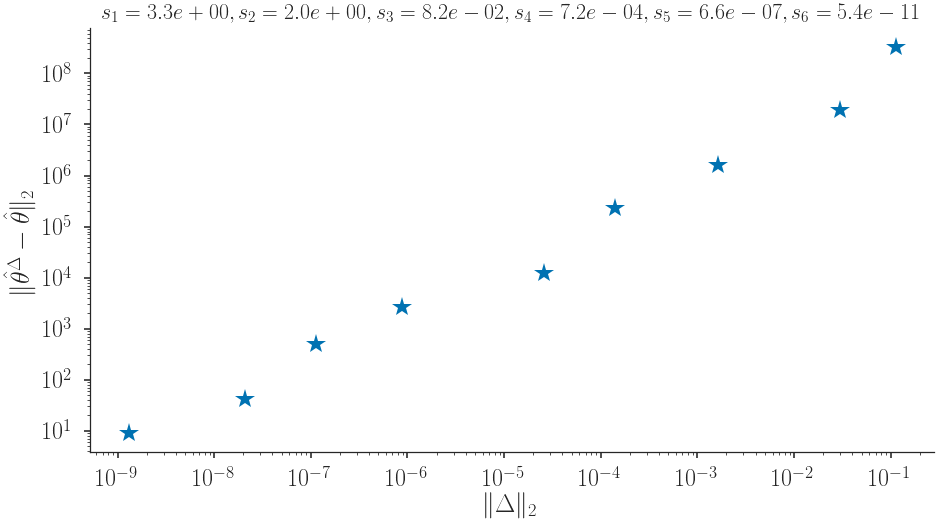

In [5]:
n_features = 6
n_samples = 10
x = 10. ** (-np.arange(n_samples,))
X = (np.column_stack([x ** (i) for i in range(n_features)]))
U, s, V = np.linalg.svd(X, full_matrices=False)
theta_true = np.ones([n_features, ])
y_true = np.dot(X, theta_true)
err = np.zeros(n_samples,)
err_delta = np.zeros(n_samples,)
for i in range(1, n_samples):
    delta = 10. ** (-i) * (0.5 - np.random.rand(n_samples, )) * y_true
    y = y_true + delta
    w = np.dot(np.transpose(U), y)
    theta_hat = np.dot(V, w / s)
    err[i] = np.sqrt(np.sum((theta_hat - theta_true) ** 2))
    err_delta[i] = np.sqrt(np.sum(delta ** 2))

sns.set_context("poster", font_scale=1.5)
sns.set_style("ticks")
fig1 = plt.figure(figsize=(14, 8))
ax1 = fig1.add_subplot(111)
ax1.plot(err_delta, err, '*', markersize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
sns.despine()
ax1.set_xlabel(r"$\|\Delta\|_2$")
ax1.set_ylabel(r"$\|\hat\theta^{\Delta}-\hat\theta\|_2$")
plt.title(r"$s_1={0: .1e}, s_2={1:.1e}, s_3={2:.1e}, s_4={3: .1e}, s_5={4: .1e}, s_6={5: .1e}$".format(s[0], s[1], s[2], s[3], s[4], s[5]), fontsize=22)
plt.tight_layout()
plt.show()

filename = "amplification_erreur"
image_name = dirname + filename + imageformat
fig1.savefig(image_name)

# Timing comparisons for various SVD solvers

adapted from http://blog.explainmydata.com/2016/01/how-much-faster-is-truncated-svd.html

In [6]:
RANK = 99
N_COLS = 2000
min_row = 100
max_rows = 1000

# Define useful functions

In [7]:
def evaluate_svd(svd_fn, reconstruct_fn, min_rows=100, max_rows=1000,
                 n_samples=10, n_cols=N_COLS, rank=RANK, random_seed=0):
    """ SVD evaluation:
    Return n_rows, time_elimes, errors
    """
    np.random.seed(random_seed)
    time_elimes = []
    errors = []
    n_rows_array = (np.linspace(min_rows, max_rows, num=n_samples)).astype(int)

    for n_rows in n_rows_array:
        # construct a low-rank matrix
        left = np.random.randn(n_rows, rank)
        right = np.random.randn(rank, n_cols)
        full = np.dot(left, right)

        # how long does it take to perform the SVD?
        start_t = time.time()
        svd_outputs = svd_fn(full)
        end_t = time.time()
        time_el = end_t - start_t
        time_elimes.append(time_el)

        # compute mean absolte error of reconstruction
        reconstructed = reconstruct_fn(svd_outputs)
        diff = full - reconstructed
        mae = np.mean(np.abs(diff))
        errors.append(mae)
        #print("n_rows=%d , time = %0.4f, MAE = %0.8f" % (n_rows, time_el, mae))
        print("n_rows=%d , time = %0.4f" % (n_rows, time_el))
    max_error = np.max(errors)
    print("Max Error=%f" % max_error)
    assert max_error < 0.0000001
    return n_rows_array, time_elimes, errors


# Full SVD with NumPy
def np_svd(X):
    """
    Compute SVD with numpy method
    """
    return np.linalg.svd(X, full_matrices=False, compute_uv=True)


def np_inv_svd(svd_outputs):
    """
    Compute reconstruction from SVD with numpy method
    """
    U, s, V = svd_outputs
    return np.dot(U, np.dot(np.diag(s), V))


# Truncated SVD with scikit-learn
def skl_svd(X, rank=RANK):
    """
    Compute SVD with skl method
    """
    tsvd = decomposition.TruncatedSVD(rank)
    X_reduced = tsvd.fit_transform(X)
    return (tsvd, X_reduced)


def skl_inv_svd(svd_outputs):
    """
    Compute reconstruction from SVD with skl method
    """
    tsvd, X_reduced = svd_outputs
    return tsvd.inverse_transform(X_reduced)


def skl_rand_svd(X, rank=RANK):
    """
    Compute approximated SVD with skl method (randomized algorithm)
    """
    tsvd = decomposition.TruncatedSVD(rank, algorithm="randomized",
                                      n_iter=1)
    X_reduced = tsvd.fit_transform(X)
    return (tsvd, X_reduced)


def skl_arpack_svd(X, rank=RANK):
    """
    Compute approximated SVD with skl method (Arpack algorithm)
    """
    tsvd = decomposition.TruncatedSVD(rank, algorithm="arpack")
    X_reduced = tsvd.fit_transform(X)
    return (tsvd, X_reduced)

# Perform timings:

In [8]:
n_rows, np_times, np_errors = evaluate_svd(np_svd, np_inv_svd)

n_rows=100 , time = 0.0117
n_rows=200 , time = 0.0259
n_rows=300 , time = 0.0491
n_rows=400 , time = 0.0808
n_rows=500 , time = 0.1020
n_rows=600 , time = 0.0977
n_rows=700 , time = 0.1267
n_rows=800 , time = 0.2255
n_rows=900 , time = 0.2222
n_rows=1000 , time = 0.3773
Max Error=0.000000


In [9]:
n_rows, skl_rand_times, skl_rand_err = evaluate_svd(skl_rand_svd, skl_inv_svd)

n_rows=100 , time = 0.0138
n_rows=200 , time = 0.0180
n_rows=300 , time = 0.0227
n_rows=400 , time = 0.0313
n_rows=500 , time = 0.0324
n_rows=600 , time = 0.0394
n_rows=700 , time = 0.0410
n_rows=800 , time = 0.0397
n_rows=900 , time = 0.0379
n_rows=1000 , time = 0.0507
Max Error=0.000000


In [10]:
n_rows, skl_arpack_times, skl_arpack_err = evaluate_svd(skl_arpack_svd,
                                                        skl_inv_svd)

n_rows=100 , time = 0.0119
n_rows=200 , time = 0.0281
n_rows=300 , time = 0.0615
n_rows=400 , time = 0.2134
n_rows=500 , time = 0.2120
n_rows=600 , time = 0.3415
n_rows=700 , time = 0.3624
n_rows=800 , time = 0.4436
n_rows=900 , time = 0.4582
n_rows=1000 , time = 0.5579
Max Error=0.000000


# Display

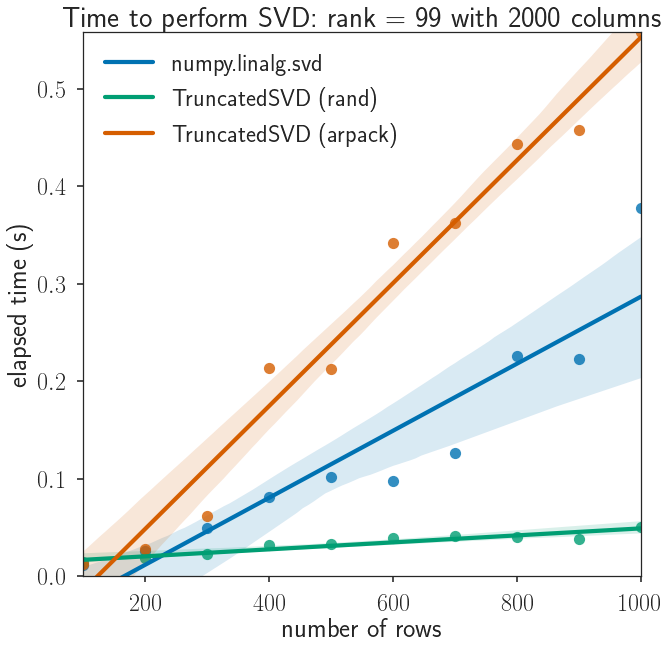

In [11]:
figure = plt.figure(figsize=(10, 10))
plt.xlim(min_row, max_rows)
plt.ylim(0, np.max([np_times, skl_rand_times, skl_arpack_times]))

x_axis = pd.Series(n_rows, name="number of rows")

sns.regplot(x=x_axis, y=pd.Series(np_times, name="elapsed time (s)"))
sns.regplot(x=x_axis, y=pd.Series(skl_rand_times, name="elapsed time (s)"))
sns.regplot(x=x_axis, y=pd.Series(skl_arpack_times, name="elapsed time (s)"))


plt.legend(("numpy.linalg.svd", "TruncatedSVD (rand)",
            "TruncatedSVD (arpack)"), loc='upper left')
plt.title("Time to perform SVD:" +
          " rank = {0} with {1} columns".format(RANK, N_COLS))
plt.show()